<a href="https://colab.research.google.com/github/eriche523/eriche523/blob/master/Copy_of_XLNet_Fine_Tuning_Sentence_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this tutorial, I'll show you how to finetune the pretrained XLNet model with the huggingface PyTorch library to quickly produce a classifier for text classification.

(This post follows the previous post on finetuning BERT very closely, but uses the updated interface of the huggingface library (pytorch-transformers) and customizes the input for use in XLNet.)

This post is presented in two forms–as a blog post here and as a Colab notebook here. The content is identical in both, but:

The blog post format may be easier to read, and includes a comments section for discussion.
The Colab Notebook will allow you to run the code and inspect it as you read through.

## What is XLNet?

XLNet is a method of pretraining language representations developed by CMU and Google researchers in mid-2019. XLNet was created to address what the authors saw as the shortcomings of the autoencoding method of pretraining used by BERT and other popular language models. We won't get into the details of XLNet in this post, but the authors favored a custom autoregressive method. This pretraining method resulted in models that outperformed BERT on a range of NLP tasks and resulted in a new state of the art model. 


## Install and Import

Google Colab offers free GPUs and TPUs! Since we'll be training a large neural network it's best to take advantage of this (in this case we'll attach a GPU), otherwise training will take a very long time.

A GPU can be added by going to the menu and selecting:

Edit -> Notebook Settings -> Add accelerator (GPU)

Then run the following cell to confirm that the GPU is detected.

In [0]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Next, let's install the pytorch interface for XLNet by Hugging Face. (This library contains interfaces for other pretrained language models like OpenAI's GPT, BERT, and GPT-2.) We've selected the pytorch interface because it strikes a nice balance between the high-level APIs (which are easy to use but don't provide insight into how things work) and tensorflow code (which contains lots of details but often sidetracks us into lessons about tensorflow)

At the moment, the Hugging Face library seems to be the most widely accepted and powerful pytorch interface for working with transfer learning models. In addition to supporting a variety of different pre-trained language models (and future models to come - just a few short months after the publication of BERT and XLNet, both have been outperformed by new models!), the library also includes pre-built modifications of different models suited to your specific task. For example, in this tutorial we will use XLNetForSequenceClassification, but the library also includes model modifications designed for token classification, question answering, next sentence prediciton, etc. Using these pre-built classes simplifies the process of modifying transfer learning models for your purposes.


In [0]:
!pip install pytorch-transformers

     |████████████████████████████████| 184kB 3.4MB/s 
     |████████████████████████████████| 870kB 58.6MB/s 
     |████████████████████████████████| 1.0MB 50.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884629 sha256=d993381b726763765ed93f2eb0d2d41bef1e6e78250a42ac124d8ee01c1e9318
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


from pytorch_transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification
from pytorch_transformers import AdamW

from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

Using TensorFlow backend.


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

## Load Dataset


We'll use The Corpus of Linguistic Acceptability (CoLA) dataset for single sentence classification. It's a set of sentences labeled as grammatically correct or incorrect. The data is as follows:

**Column 1**:	the code representing the source of the sentence.

**Column 2**:	the acceptability judgment label (0=unacceptable, 1=acceptable).

**Column 3**:	the acceptability judgment as originally notated by the author.

**Column 4**:	the sentence.

Download the dataset from this link, extract, and move them to your local drive.

https://nyu-mll.github.io/CoLA/

Both tokenized and raw versions of the data are available. We will use the **raw** version because we need to use the XLNet tokenizer to break the text down into tokens and chunks that the model will recognize.

In [0]:
# Upload the train file from your local drive
from google.colab import files
uploaded = files.upload()

In [0]:
df = pd.read_csv("in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

In [0]:
df.shape

(8551, 4)

In [0]:
df.sample(10)

,sentence_source,label,label_notes,sentence
5841,c_13,1,NaN,I think that he eats asparagus.
3429,ks08,1,NaN,"The ball, a man kicked."
2510,l-93,1,NaN,The door was pushed open.
5350,b_73,0,*,A tangerine isn't as much different from an or...
4591,ks08,1,NaN,"As a statesman, he scarcely could do anything ..."
7122,sgww85,0,*,Pat was annoyed by that their parents did noth...
4301,ks08,0,*,Stephen persuaded the cat to be out of the bag.
8350,ad03,1,NaN,Who has drunk my whiskey?
8131,ad03,0,*,She kicked itself
7922,ad03,0,*,I have might be flying helicopters.


In [0]:
# Create sentence and label lists
sentences = df.sentence.values

We need to add special tokens ("[SEP]" and "[CLS]") at the beginning and end of each sentence for XLNet to work properly. 

For BERT, the special token pattern looks like this:

    [CLS] + Sentence_A + [SEP] + Sentence_B + [SEP]

Whereas with XLNet the token pattern looks like this:

    Sentence_A + [SEP] + Sentence_B + [SEP] + [CLS]
    
For single sentence inputs here, we just need to add [SEP] and [CLS] to the end:

In [0]:
sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]
labels = df.label.values

## Inputs

In [0]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-large-cased', do_lower_case=True)

100%|██████████| 798011/798011 [00:00<00:00, 5471335.98B/s]


Next, import the XLNet tokenizer, used to convert our text into tokens that correspond to XLNet's vocabulary.

In [0]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

100%|██████████| 798011/798011 [00:00<00:00, 4627375.11B/s]


NameError: ignored

XLNet requires specifically formatted inputs. For each tokenized input sentence, we need to create:

- **input ids**: a sequence of integers identifying each input token to its index number in the XLNet tokenizer vocabulary
- **segment mask**: (optional) a sequence of 1s and 0s used to identify whether the input is one sentence or two sentences long. For one sentence inputs, this is simply a sequence of 0s. For two sentence inputs, there is a 0 for each token of the first sentence, followed by a 1 for each token of the second sentence
- **attention mask**: (optional) a sequence of 1s and 0s, with 1s for all input tokens and 0s for all padding tokens (we'll detail this in the next paragraph)
- **labels**: a single value of 1 or 0. In our task 1 means "grammatical" and 0 means "ungrammatical"

Although we can have variable length input sentences, XLNet does requires our input arrays to be the same size. We address this by first choosing a maximum sentence length, and then padding and truncating our inputs until every input sequence is of the same length. 

To "pad" our inputs in this context means that if a sentence is shorter than the maximum sentence length, we simply add 0s to the end of the sequence until it is the maximum sentence length. 

If a sentence is longer than the maximum sentence length, then we simply truncate the end of the sequence, discarding anything that does not fit into our maximum sentence length.

We pad and truncate our sequences so that they all become of length MAX_LEN ("post" indicates that we want to pad and truncate at the end of the sequence, as opposed to the beginning) `pad_sequences` is a utility function that we're borrowing from Keras. It simply handles the truncating and padding of Python lists.

In [0]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
MAX_LEN = 128

In [0]:
# Use the XLNet tokenizer to convert the tokens to their index numbers in the XLNet vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [0]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

Create the attention masks 

In [0]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [0]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [0]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [0]:
# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


## Train Model

Now that our input data is properly formatted, it's time to fine tune the XLNet model. 

For this task, we first want to modify the pre-trained model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task. Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained model, each has different top layers and output types designed to accomodate their specific NLP task.  

We'll load [XLNetForSequenceClassification](https://github.com/huggingface/pytorch-transformers/blob/master/pytorch_transformers/modeling_xlnet.py#L1076). This is the normal XLNet model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained XLNet model and the additional untrained classification layer is trained on our specific task. 

### The Fine-Tuning Process

Because the pre-trained model layers already encode a lot of information about the language, training the classifier is relatively inexpensive. Rather than training every layer in a large model from scratch, it's as if we have already trained the bottom layers 95% of where they need to be, and only really need to train the top layer, with a bit of tweaking going on in the lower levels to accomodate our task.

Sometimes practicioners will opt to "freeze" certain layers when fine-tuning, or to apply different learning rates, apply diminishing learning rates, etc. all in an effort to preserve the good quality weights in the network and speed up training (often considerably). In fact, recent research on transfer learning models like BERT specifically has demonstrated that freezing the majority of the weights results in only minimal accuracy declines, but there are exceptions and broader rules of transfer learning that should also be considered. For example, if your task and fine-tuning dataset is very different from the dataset used to train the transfer learning model, freezing the weights may not be a good idea. We'll cover the broader scope of transfer learning in NLP in a future post.  



OK, let's load XLNet! There are a few different pre-trained XLNet models available. "xlnet-base-cased" means the version that has both upper and lowercase letters ("cased") and is the smaller version of the two ("base" vs "large").

In [0]:
# Load XLNEtForSequenceClassification, the pretrained XLNet model with a single linear classification layer on top. 

model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2)
model.cuda()

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend the following hyperparameters in the following ranges (broken down by which NLP dataset they are applied to):


![alt text](https://i.imgur.com/AhirErN.png)

In [0]:

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0},
]



In [0]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters,
                     lr=2e-5)

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a training phase and a validation phase. At each pass we need to:

Training loop:
- Tell the model to compute gradients by setting the model in train mode
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

Evalution loop:
- Tell the model not to compute gradients by setting th emodel in evaluation mode
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

So please read carefully through the comments to get an understanding of what's happening. If you're unfamiliar with pytorch a quick look at some of their [beginner tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) will help show you that training loops really involve only a few simple steps; the rest is usually just decoration and logging.  

In [0]:
b_input_ids.type

<function Tensor.type>

In [0]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 20

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    logits = outputs[1]
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      logits = output[0]
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
 
  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 0.6149730255742291


Epoch:   5%|▌         | 1/20 [04:05<1:17:37, 245.12s/it]

Validation Accuracy: 0.6925154320987654
Train loss: 0.5749313123987918


Epoch:  10%|█         | 2/20 [08:10<1:13:34, 245.23s/it]

Validation Accuracy: 0.7472993827160493
Train loss: 0.4542582321958423


Epoch:  15%|█▌        | 3/20 [12:16<1:09:30, 245.31s/it]

Validation Accuracy: 0.773533950617284
Train loss: 0.33719563614036036


Epoch:  20%|██        | 4/20 [16:21<1:05:25, 245.35s/it]

Validation Accuracy: 0.7669753086419753
Train loss: 0.2399738729154668


Epoch:  25%|██▌       | 5/20 [20:26<1:01:20, 245.37s/it]

Validation Accuracy: 0.7901234567901234
Train loss: 0.1752981957419161


Epoch:  30%|███       | 6/20 [24:32<57:15, 245.38s/it]  

Validation Accuracy: 0.7870370370370371
Train loss: 0.12508946737560495


Epoch:  35%|███▌      | 7/20 [28:37<53:10, 245.39s/it]

Validation Accuracy: 0.7843364197530863
Train loss: 0.11778787186145165


Epoch:  40%|████      | 8/20 [32:43<49:04, 245.41s/it]

Validation Accuracy: 0.7993827160493827
Train loss: 0.08721850613804526


Epoch:  45%|████▌     | 9/20 [36:48<44:59, 245.41s/it]

Validation Accuracy: 0.7924382716049382
Train loss: 0.0787861556919964


Epoch:  50%|█████     | 10/20 [40:54<40:54, 245.46s/it]

Validation Accuracy: 0.7912808641975309
Train loss: 0.057946127213352204


Epoch:  55%|█████▌    | 11/20 [44:59<36:49, 245.47s/it]

Validation Accuracy: 0.7935956790123456
Train loss: 0.05626481567235099


Epoch:  60%|██████    | 12/20 [49:05<32:43, 245.46s/it]

Validation Accuracy: 0.7851080246913581
Train loss: 0.056456143471230735


Epoch:  65%|██████▌   | 13/20 [53:10<28:38, 245.44s/it]

Validation Accuracy: 0.788966049382716
Train loss: 0.05398449935482745


Epoch:  70%|███████   | 14/20 [57:16<24:32, 245.45s/it]

Validation Accuracy: 0.7970679012345678
Train loss: 0.03933661796647236


Epoch:  75%|███████▌  | 15/20 [1:01:21<20:27, 245.46s/it]

Validation Accuracy: 0.7935956790123456
Train loss: 0.04675860822594945


Epoch:  80%|████████  | 16/20 [1:05:26<16:21, 245.46s/it]

Validation Accuracy: 0.8020833333333334
Train loss: 0.033144979396664935


Epoch:  85%|████████▌ | 17/20 [1:09:32<12:16, 245.47s/it]

Validation Accuracy: 0.7866512345679012
Train loss: 0.03157141484432231


Epoch:  90%|█████████ | 18/20 [1:13:37<08:10, 245.46s/it]

Validation Accuracy: 0.8128858024691359
Train loss: 0.032844693130423236


Epoch:  95%|█████████▌| 19/20 [1:17:43<04:05, 245.47s/it]

Validation Accuracy: 0.8128858024691359
Train loss: 0.02914806254810936


Epoch: 100%|██████████| 20/20 [1:21:48<00:00, 245.48s/it]

Validation Accuracy: 0.8040123456790123


## Training Evaluation

Let's take a look at our training loss over all batches:

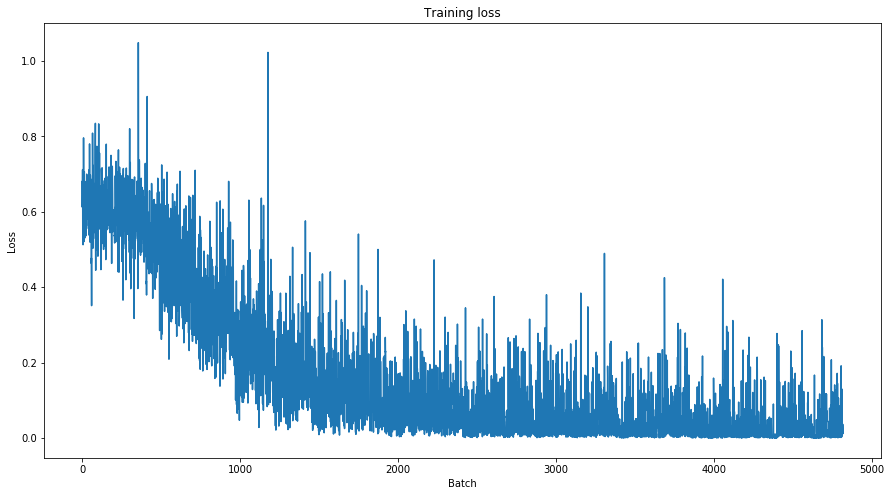

In [0]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

##Predict and Evaluate on Holdout Set

Now we'll load the holdout dataset and prepare inputs just as we did with the training set. Then we'll evaluate predictions using [Matthew's correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) because this is the metric used by the wider NLP community to evaluate performance on CoLA. With this metric, +1 is the best score, and -1 is the worst score. This way, we can see how well we perform against the state of the art models for this specific task.

In [0]:
# Upload the test file from your local drive
from google.colab import files
uploaded = files.upload()


Saving out_of_domain_dev.tsv to out_of_domain_dev.tsv


In [0]:
df = pd.read_csv("out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for XLNet to work properly
sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128

# Use the XLNet tokenizer to convert the tokens to their index numbers in the XLNet vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [0]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [0]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


The final score will be based on the entire test set, but let's take a look at the scores on the individual batches to get a sense of the variability in the metric between batches.


In [0]:
matthews_set

[0.21713222235566895,
 -0.1210898699241207,
 0.4040950971038548,
 0.12562244381357196,
 0.3567530340063379,
 0.6397114734243627,
 0.6201736729460423,
 0.20261022461827694,
 0.7453559924999299,
 0.4581228472908512,
 0.41179801403140964,
 0.5465943944999485,
 0.7562449037944323,
 0.8958064164776167,
 0.5447047794019222,
 0.2321726094326961,
 0.0]

In [0]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]


In [0]:
matthews_corrcoef(flat_true_labels, flat_predictions)

0.4618816547403781

In [0]:
from sklearn.metrics import accuracy_score, classification_report

print (accuracy_score(flat_true_labels, flat_predictions))

print (classification_report(flat_true_labels, flat_predictions))

0.7829457364341085
              precision    recall  f1-score   support

           0       0.84      0.38      0.53       162
           1       0.77      0.97      0.86       354

    accuracy                           0.78       516
   macro avg       0.81      0.67      0.69       516
weighted avg       0.79      0.78      0.75       516



Cool, we've fine-tuned XLNet!

Our initial score isn't great, so it would be a good idea to try out some hyperparameter tuning (adjusting the learning rate, epochs, batch size, optimizer properties, etc.) in order to get a better score. I should also mention we didn't train on the entire training dataset, but set aside a portion of it as our validation set for legibililty of code.



## Conclusion

This post shows how to quickly and efficiently train an XLNet model with the huggingface pytorch interface.